# Seattle Rentals on airbnb

This notebook explores a dataset of airbnb rentals in Seattle.  In particular, three questions are of primary interest

Concerning airbnb rentals in Seattle..
1. How does neighbourhood affect the price?  Which neighbourhoods are most expensive?
2. How do review scores affect the price?
3. How effectively can we predict the price using a machine learning model?

### Import Python Libraries and Configure Settings

In [191]:
#Core Libraries
import pandas as pd
import numpy as np
import warnings

#Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression,SGDRegressor,Lasso,ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

#Settings
warnings.simplefilter('ignore')
sns.set(style="darkgrid")
sns.set(font_scale=2) 
dimensions = (20, 8)
%matplotlib inline

## Import the Data 
Three data sets are available.  We will import all three and consider their use for the task at hand

In [192]:
calendar = pd.read_csv('Seattle/calendar.csv')
listings = pd.read_csv('Seattle/listings.csv')
reviews = pd.read_csv('Seattle/reviews.csv')

## Explore Calendar Data

In [193]:
calendar.shape

(1393570, 4)

In [194]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [195]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [196]:
#What is the date range of our data?
calendar['date'].agg(['min', 'max', 'nunique'])

min        2016-01-04
max        2017-01-02
nunique           365
Name: date, dtype: object

In [197]:
#Do we have any missing values in any of the columns?
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [198]:
#How many unique properites are in our data set?
calendar['listing_id'].nunique()

3818

In [199]:
#What data is in the available column?
calendar['available'].value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [200]:
#Is price always present when available = t?
calendar.groupby('available')['price'].agg(['count'])

,count
available,
f,0
t,934542


In [201]:
#Do we have data for each property for every day ?
calendar.groupby('listing_id')['date'].count().agg(['min', 'max'])

min    365
max    365
Name: date, dtype: int64

We have calendar data for 3,818 properties spanning 365 days.  We appear to have a full year's worth of data for each property.  Each row appears to represent whether a specific property (identified by the listing_id) is available for rent (at the time this data was collected).  If the available column is "t" (for true) then the price column is po

## Explore Reviews Data

In [202]:
reviews.shape

(84849, 6)

In [203]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [204]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [205]:
#Do we have any missing vaules in our data?
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [206]:
reviews.groupby('listing_id').count().sort_values('id', ascending=False)

,id,date,reviewer_id,reviewer_name,comments
listing_id,,,,,
208356,474,474,474,474,474
365550,466,466,466,466,466
25002,404,404,404,404,404
47196,353,353,353,353,353
63308,320,320,320,320,320
...,...,...,...,...,...
6292452,1,1,1,1,1
6305798,1,1,1,1,1
8080939,1,1,1,1,1


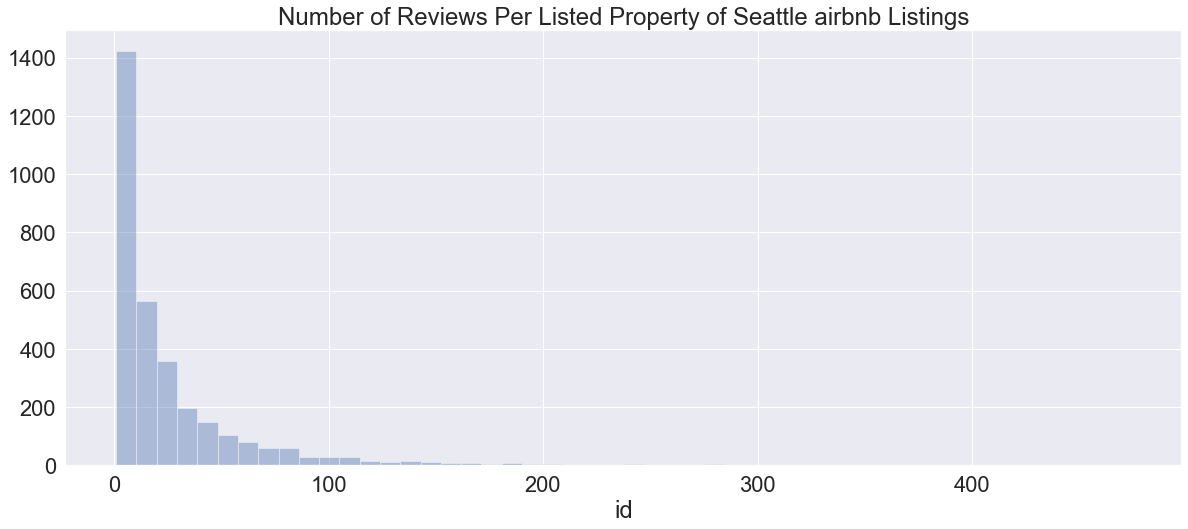

In [207]:
#Get count of reviews per listing
reviews_per_listing = reviews.groupby('listing_id')['id'].count()

#Plot Histogram of the listings count
fig, ax = plt.subplots(figsize = dimensions)
sns.distplot(reviews_per_listing,kde = False)
ax.set_title('Number of Reviews Per Listed Property of Seattle airbnb Listings')
plt.show()

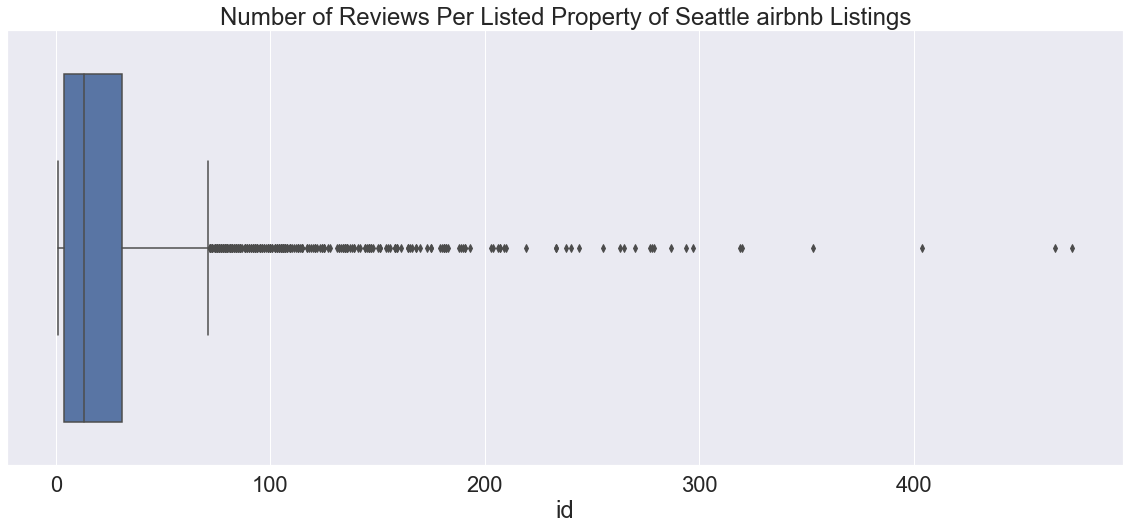

In [208]:
#Boxplot of revies per listing
fig, ax = plt.subplots(figsize = dimensions)
ax.set_title('Number of Reviews Per Listed Property of Seattle airbnb Listings')
ax = sns.boxplot(x=reviews_per_listing)

In [209]:
#Print some summary statistics
print('Reviews per listing (Mode):', reviews_per_listing.mode()[0])
print('Reviews per listing (1st Quartile):', reviews_per_listing.quantile(0.25))
print('Reviews per listing (Median):', reviews_per_listing.median())
print('Reviews per listing (3rd Quartile):', reviews_per_listing.quantile(0.75))
print('Reviews per listing (Mean):', reviews_per_listing.mean())
print('Reviews per listing (Min):', reviews_per_listing.min())
print('Reviews per listing (Max):', reviews_per_listing.max())

Reviews per listing (Mode): 1
Reviews per listing (1st Quartile): 4.0
Reviews per listing (Median): 13.0
Reviews per listing (3rd Quartile): 31.0
Reviews per listing (Mean): 26.590097148229397
Reviews per listing (Min): 1
Reviews per listing (Max): 474


The histogram and boxplot clearly show that the number of reviews per property is right-skewed.  Most properties have relatively few reviews, but there are many outliers with a high number of reviews. A quarter of the properties have 4 reviews or fewer, half the properties have 13 reviews or fewer.

## Explore Listings Data

In [210]:
listings.shape

(3818, 92)

In [211]:
listings.columns.to_list()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',


In [212]:
#What data types do we have in the listings data?
listings.dtypes.value_counts()

object     62
float64    17
int64      13
dtype: int64

In [213]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [214]:
#Identify the columns with null values
null_columns = listings.columns[listings.isnull().sum() > 0]
null_columns

Index(['summary', 'space', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'zipcode', 'property_type', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'reviews_per_month'],
      dtype='object')

In [215]:
#How many nulls do we have in these columns?
listings[null_columns].isnull().sum().sort_values(ascending=False)

license                        3818
square_feet                    3721
monthly_price                  2301
security_deposit               1952
weekly_price                   1809
notes                          1606
neighborhood_overview          1032
cleaning_fee                   1030
transit                         934
host_about                      859
host_acceptance_rate            773
review_scores_accuracy          658
review_scores_checkin           658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
reviews_per_month               627
first_review                    627
last_review                     627
space                           569
host_response_time              523
host_response_rate              523
neighbourhood                   416
thumbnail_url                   320
medium_url                      320
xl_picture_url              

Some columns have many null values.  If we wish to use these as features in the model we will either need to drop null rows or impute the missing values.  Some columns have so many null values it would be better to omit these from the model entirely.

In [216]:
#Identify the columns which have no null values
complete_columns = listings.columns[listings.isnull().sum() == 0]
complete_columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'experiences_offered', 'picture_url', 'host_id', 'host_url',
       'host_verifications', 'street', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'room_type', 'accommodates', 'bed_type',
       'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count'],
      dtype='object')

In [217]:
#Get some numerical summaries of the numeric vairables.
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


Many of these numeric variables have values for all columns (count = 3818).  Some are only missing in a few rows.  Many of these will be good candidates for features in a model.  The ID columns are numeric but they are not suitable for use as features. 

In [218]:
#Let's look at the object columns
pd.set_option('display.max_columns', None)
listings.select_dtypes('object').head()

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/241032,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,t,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,NaN,NaN,$5.00,4 weeks ago,t,2016-01-04,2011-11-01,2016-01-02,f,WASHINGTON,f,moderate,f,f
1,https://www.airbnb.com/rooms/953595,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,t,Apartment,Entire home/apt,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00,today,t,2016-01-04,2013-08-19,2015-12-29,f,WASHINGTON,f,strict,t,t
2,https://www.airbnb.com/rooms/3308979,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a...,NaN,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...,Queen Anne,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Qu

Some of these columns look like they might be promising for features.  Some columns contains multiple values (e.g. host_verifications and amenities).  These will need to be split out if they are to be used.

## Explore Price 

Price is the key variable of interest. We aim to produce a machine learning model to predict price using some of the other variables as input features.  We will need to conduct some EDA first.

In [219]:
#Check data type of price
listings['price'].dtype

dtype('O')

In [220]:
listings['price'].head()

0     $85.00
1    $150.00
2    $975.00
3    $100.00
4    $450.00
Name: price, dtype: object

Price is an object variable as it contains a leading dollar sign.  Need to strip the dollar sign and convert this to numeric.


In [221]:
#Strip the dollar signs
listings['price'] = listings['price'].str.replace('$', '')

#Convert to numeric
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

#Do we have any null values?
listings['price'].isnull().sum()

1

After coercing to numeric, we have one missing value.  We will remove this row from the dataset.

In [222]:
#Drop null values
listings = listings[listings['price'].notnull()]

#Confirm we now have 0 null values?
listings['price'].isnull().sum()

0

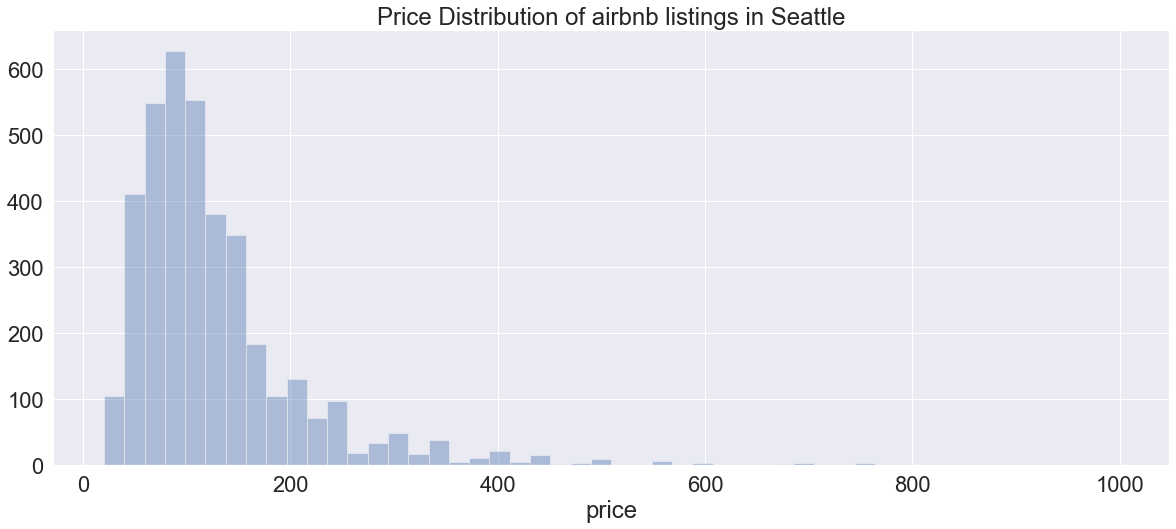

In [223]:
#Plot price distribution as histrogram
fig, ax = plt.subplots(figsize = dimensions)
sns.distplot(listings['price'],kde = False)
ax.set_title('Price Distribution of airbnb listings in Seattle')
plt.show()

In [224]:
#Subselect the numeric columns
numeric_df = listings.select_dtypes(['float64','int64'])

#Drop some of the numeric columns, such as IDs which will not be helpful
#Latitude and logitude unlikely to be helpful in a linear model, neighbourhood will discriminate by area
#License is all nulls so drop
numeric_df.drop(['id', 'scrape_id', 'host_id',  'latitude', 'longitude','license'], axis=1, inplace=True)

Text(0.5, 1, 'Correlation Matrix of Numeric Variables in Seattle airbnb Listings Data')

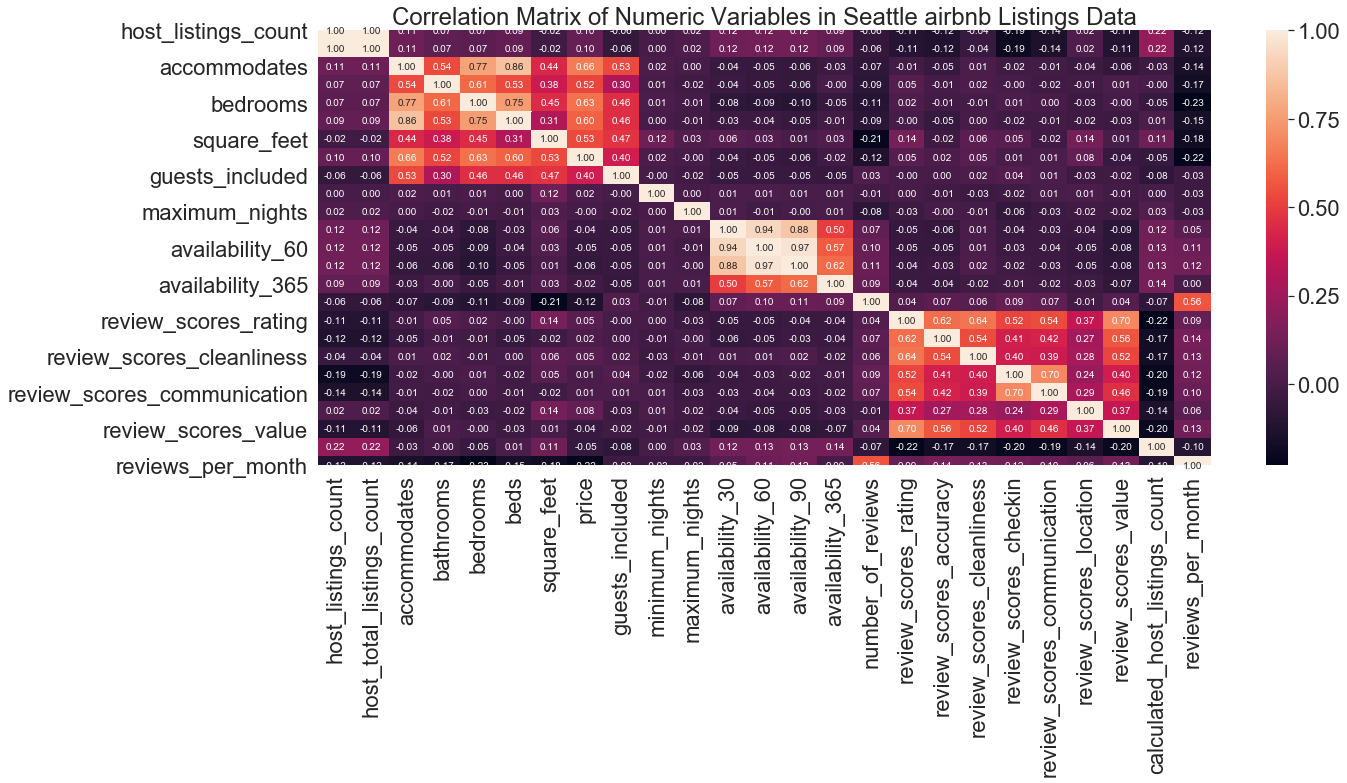

In [225]:
#Plot correlation matrix
fig, ax = plt.subplots(figsize = dimensions)
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f')
ax.set_title('Correlation Matrix of Numeric Variables in Seattle airbnb Listings Data')

By scanning the price row we can get a good initial feel for what variables are likely to make good predictive features in a model.  

The following look like good features, higher values in these columns tend to correlate with a higher price:
* accomodates
* bathrooms
* bedrooms
* beds
* square_feet
* guests_included

These all match up with our intuitions.  They are all indicators of the size of the property, and it's understandable that bigger properties with more space would command a higher price.

No variables have an especially high negative correlation although reviews and reviews_per_month have the biggest negative correlations.  This seems somewhat surprising as it suggests that listings with more reviews tend to command a lower price.

The distribution of price is clearly right skewed

In [226]:
#Does the property type affect the price?
price_by_property_type = listings.groupby('property_type').agg({ 'price' : ['count', 'min', 'mean', 'median', 'max', 'std']}).sort_values(('price','count'), ascending=False)
display(price_by_property_type)

price                                             
                count    min        mean median    max         std
property_type                                                     
House            1732   25.0  131.850462   95.0  975.0  104.853925
Apartment        1708   20.0  122.932670  110.0  999.0   66.617706
Townhouse         118   28.0  129.457627   97.0  498.0   92.397103
Condominium        91   50.0  151.109890  115.0  700.0  111.091099
Loft               40   25.0  135.700000  102.5  425.0   79.825836
Bed & Breakfast    37   30.0  112.054054   99.0  299.0   55.840022
Other              22   39.0   94.681818   86.5  170.0   40.449129
Cabin              21   52.0  104.666667   95.0  300.0   55.218053
Bungalow           13   65.0  115.615385   95.0  349.0   75.226922
Camper/RV          13   45.0  120.461538   82.0  375.0   95.375237
Boat                8   75.0  282.375000  150.0  775.0  281.327434
Tent                5   25.0   54.000000   65.0   65.0   17.464249
Treehouse           3   48.0  101.000000   55.0  200.0   85.807925
Chalet              2   62.0   98.500000   98.5  135.0   51.618795
Dorm                2   38.0   39.500000   39.5   41.0    2.121320
Yurt                1  100.0  100.000000  100.0  100.0         NaN

Text(0.5, 1.0, 'Price of airbnb listings in Seattle by Property Type')

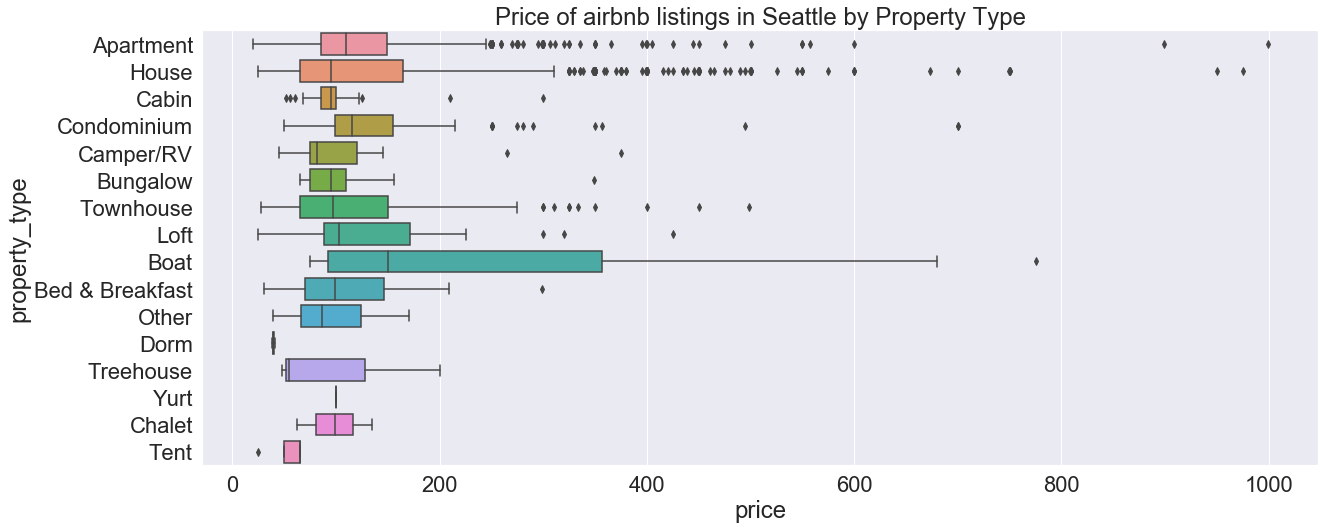

In [227]:
#Visualise the distribution of price by property type
fig, ax = plt.subplots(figsize = dimensions)
ax = sns.boxplot(x="price", y="property_type", data=listings)
ax.set_title('Price of airbnb listings in Seattle by Property Type')

Text(0.5, 1.0, 'Price of airbnb listings in Seattle by Most Common Property Types')

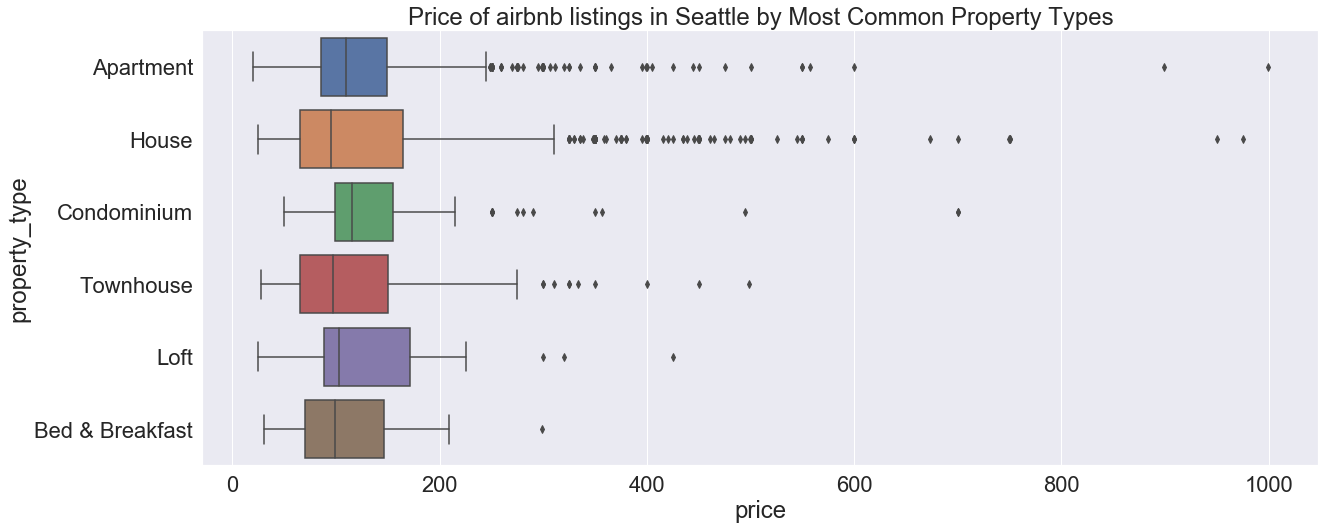

In [228]:
top_6_property_types = pd.Series(price_by_property_type.iloc[0:6, 0].index)
top_6_properties_df = listings[listings['property_type'].isin(top_6_property_types)]

fig, ax = plt.subplots(figsize = dimensions)
ax = sns.boxplot(x="price", y="property_type", data=top_6_properties_df)
ax.set_title('Price of airbnb listings in Seattle by Most Common Property Types')

In [229]:
#Does being a superhost affect the price?
price_by_superhost = listings.groupby('host_is_superhost').agg({ 'price' : ['count', 'min', 'mean', 'max', 'std']}).sort_values(('price','count'), ascending=False)
display(price_by_superhost)

price                                    
                  count   min        mean    max        std
host_is_superhost                                          
f                  3037  20.0  127.104050  999.0  89.565731
t                   778  30.0  130.140103  750.0  87.528320

Text(0.5, 1.0, 'Average Price of Seattle airbnb listings for Superhosts and Non-Superhosts')

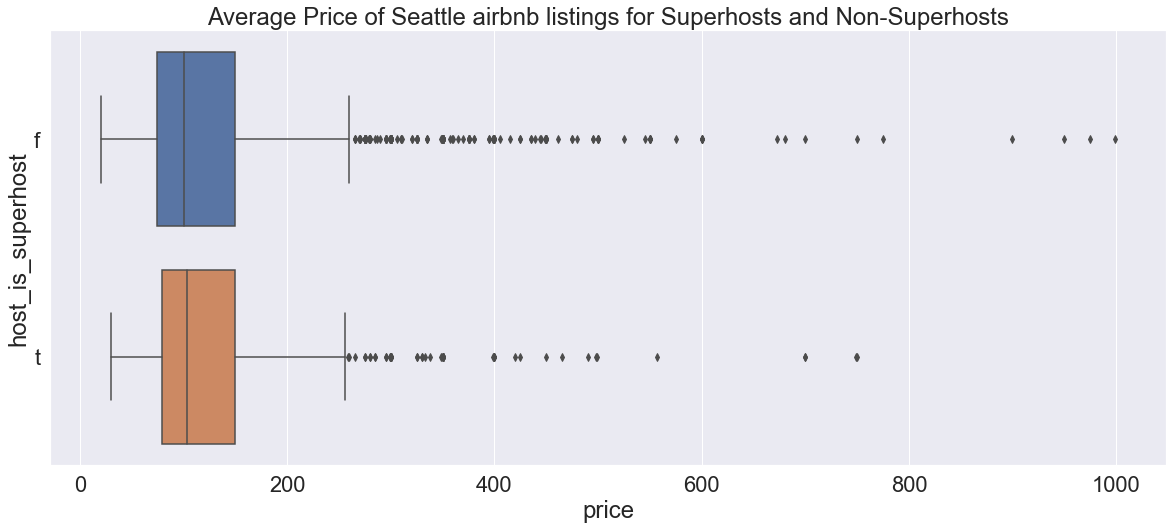

In [230]:
fig, ax = plt.subplots(figsize = dimensions)
ax = sns.boxplot(x="price", y="host_is_superhost", data=listings)
ax.set_title('Average Price of Seattle airbnb listings for Superhosts and Non-Superhosts')

The median price is slightly higher for superhosts.  It's not clear that this difference is significant there could be other variables at play.

In [231]:
#Check the some of the variables which indicate the geographic area
print(listings['city'].value_counts())
print(listings['state'].value_counts())
print(listings['market'].value_counts())

Seattle                  3809
Seattle                     2
West Seattle                2
西雅图                         1
Phinney Ridge Seattle       1
Ballard, Seattle            1
seattle                     1
Name: city, dtype: int64
WA    3816
wa       1
Name: state, dtype: int64
Seattle    3817
Name: market, dtype: int64


All these variables (cuty, state and market) basically indicate 'Seattle' with some rogue valuues.  These are not useful as our analysis is already limited to Seattle.

## Cleaning Data for Model

In [232]:
#Target to use in model
target = 'price'

#Copy data frame
df = listings.copy(deep=True)

#Confirm we have no null values
df[target].isnull().sum()

0

### Host Verifications

In [233]:
#Check host-verifications
df['host_verifications'].head()

0                 ['email', 'phone', 'reviews', 'kba']
1    ['email', 'phone', 'facebook', 'linkedin', 're...
2     ['email', 'phone', 'google', 'reviews', 'jumio']
3    ['email', 'phone', 'facebook', 'reviews', 'jum...
4     ['email', 'phone', 'facebook', 'reviews', 'kba']
Name: host_verifications, dtype: object

In [234]:
#Host verifications is a string, convert to a list
df['host_verifications2'] = df['host_verifications'].str.replace('[', '').str.replace(']', '').str.replace('\'', '').str.split(', ')

In [235]:
#Combine all host verifications in a list
verification_list = [val for x in df['host_verifications2'] for val in x]

In [236]:
#Get deduplicated verifcation types
verification_types = list(dict.fromkeys(verification_list))

In [237]:
#Check verification types
verification_types

['email',
 'phone',
 'reviews',
 'kba',
 'facebook',
 'linkedin',
 'jumio',
 'google',
 'manual_offline',
 'amex',
 'manual_online',
 'sent_id',
 'photographer',
 '',
 'None',
 'weibo']

In [238]:
#Remove missing values from verification types list
verification_types.remove('None')
verification_types.remove('')

In [239]:
#Create helper function 
def list_contains(alist, val):
  """Check if the supplied list alist supplied list contains the supplied value (val)
  
   Parameters: 
    alist : a list of values
    val : value to check for in list
  
    Returns: 
    int: 1 if val present in alist, 0 if not 
  
  """
  for i in alist:
    if(i == val):
        return 1
  return 0

In [240]:
#create empty list
verification_features = []

#Loop through the distinct verifcation_types we have found and create a new categorical column for each
for val in verification_types:
    verification_feature = 'host_verifications_' + val
    df[verification_feature] = df['host_verifications2'].apply(lambda x : list_contains(x, val))
    verification_features.append(verification_feature)

In [241]:
#Check our verification features we have created.
verification_features

['host_verifications_email',
 'host_verifications_phone',
 'host_verifications_reviews',
 'host_verifications_kba',
 'host_verifications_facebook',
 'host_verifications_linkedin',
 'host_verifications_jumio',
 'host_verifications_google',
 'host_verifications_manual_offline',
 'host_verifications_amex',
 'host_verifications_manual_online',
 'host_verifications_sent_id',
 'host_verifications_photographer',
 'host_verifications_weibo']

In [242]:
#Check our newly create host verification features
#The mean represents how many of our listings have that particular host_verification type
df[verification_features].describe()

,host_verifications_email,host_verifications_phone,host_verifications_reviews,host_verifications_kba,host_verifications_facebook,host_verifications_linkedin,host_verifications_jumio,host_verifications_google,host_verifications_manual_offline,host_verifications_amex,host_verifications_manual_online,host_verifications_sent_id,host_verifications_photographer,host_verifications_weibo
count,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000
mean,0.970658,0.992926,0.929526,0.475504,0.504847,0.233429,0.337700,0.194917,0.013623,0.006550,0.003406,0.002358,0.001048,0.001310
std,0.168787,0.083818,0.255978,0.499465,0.500042,0.423069,0.472988,0.396189,0.115936,0.080675,0.058268,0.048507,0.032359,0.036174
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [243]:
#Check host verifications correlation with price
df[verification_features + ['price']].corr()['price'].sort_values()

host_verifications_google           -0.043368
host_verifications_reviews          -0.037824
host_verifications_phone            -0.030469
host_verifications_weibo            -0.030451
host_verifications_email            -0.024856
host_verifications_amex             -0.014017
host_verifications_facebook         -0.010116
host_verifications_jumio            -0.006599
host_verifications_photographer     -0.004814
host_verifications_manual_offline    0.001676
host_verifications_sent_id           0.010682
host_verifications_kba               0.027466
host_verifications_manual_online     0.031594
host_verifications_linkedin          0.048773
price                                1.000000
Name: price, dtype: float64

All the host verification indicators have low correlation scores.  They may not be very helpful predictive features in the model.

### Amenities

In [244]:
df['amenities'].head()

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

In [245]:
#Amenities is a string, convert to a list
df['amenities2'] = df['amenities'].str.replace('{','').str.replace('}','').str.replace('"', '').str.split(',')

In [246]:
#Combine all amenities in a list
amenities_list = [val for x in df['amenities2'] for val in x]

In [247]:
#Get deduplicated verifcation types
amenities_types = list(dict.fromkeys(amenities_list))

In [248]:
amenities_types

['TV',
 'Cable TV',
 'Internet',
 'Wireless Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Free Parking on Premises',
 'Buzzer/Wireless Intercom',
 'Smoke Detector',
 'Carbon Monoxide Detector',
 'First Aid Kit',
 'Safety Card',
 'Fire Extinguisher',
 'Essentials',
 'Pets Allowed',
 'Pets live on this property',
 'Dog(s)',
 'Cat(s)',
 'Hot Tub',
 'Indoor Fireplace',
 'Shampoo',
 'Breakfast',
 '24-Hour Check-in',
 'Hangers',
 'Hair Dryer',
 'Iron',
 'Laptop Friendly Workspace',
 'Suitable for Events',
 'Elevator in Building',
 'Lock on Bedroom Door',
 'Wheelchair Accessible',
 'Gym',
 '',
 'Pool',
 'Smoking Allowed',
 'Other pet(s)',
 'Doorman',
 'Washer / Dryer']

In [249]:
#Remove missing values from verification types list
amenities_types.remove('')

In [250]:
amenities_features = []

#Loop through the distinct amentity types we have found and create a new categorical column for each
for val in amenities_types:
    amenities_feature = 'amenity_' + val
    df[amenities_feature] = df['amenities2'].apply(lambda x : list_contains(x, val))
    amenities_features.append(amenities_feature)

In [251]:
#Check our amenity features
amenities_features

['amenity_TV',
 'amenity_Cable TV',
 'amenity_Internet',
 'amenity_Wireless Internet',
 'amenity_Air Conditioning',
 'amenity_Kitchen',
 'amenity_Heating',
 'amenity_Family/Kid Friendly',
 'amenity_Washer',
 'amenity_Dryer',
 'amenity_Free Parking on Premises',
 'amenity_Buzzer/Wireless Intercom',
 'amenity_Smoke Detector',
 'amenity_Carbon Monoxide Detector',
 'amenity_First Aid Kit',
 'amenity_Safety Card',
 'amenity_Fire Extinguisher',
 'amenity_Essentials',
 'amenity_Pets Allowed',
 'amenity_Pets live on this property',
 'amenity_Dog(s)',
 'amenity_Cat(s)',
 'amenity_Hot Tub',
 'amenity_Indoor Fireplace',
 'amenity_Shampoo',
 'amenity_Breakfast',
 'amenity_24-Hour Check-in',
 'amenity_Hangers',
 'amenity_Hair Dryer',
 'amenity_Iron',
 'amenity_Laptop Friendly Workspace',
 'amenity_Suitable for Events',
 'amenity_Elevator in Building',
 'amenity_Lock on Bedroom Door',
 'amenity_Wheelchair Accessible',
 'amenity_Gym',
 'amenity_Pool',
 'amenity_Smoking Allowed',
 'amenity_Other pet(s

In [252]:
#Check our newly created amenity features
#The mean represents how many of our listings have that particular amenity
df[amenities_features].describe()

,amenity_TV,amenity_Cable TV,amenity_Internet,amenity_Wireless Internet,amenity_Air Conditioning,amenity_Kitchen,amenity_Heating,amenity_Family/Kid Friendly,amenity_Washer,amenity_Dryer,amenity_Free Parking on Premises,amenity_Buzzer/Wireless Intercom,amenity_Smoke Detector,amenity_Carbon Monoxide Detector,amenity_First Aid Kit,amenity_Safety Card,amenity_Fire Extinguisher,amenity_Essentials,amenity_Pets Allowed,amenity_Pets live on this property,amenity_Dog(s),amenity_Cat(s),amenity_Hot Tub,amenity_Indoor Fireplace,amenity_Shampoo,amenity_Breakfast,amenity_24-Hour Check-in,amenity_Hangers,amenity_Hair Dryer,amenity_Iron,amenity_Laptop Friendly Workspace,amenity_Suitable for Events,amenity_Elevator in Building,amenity_Lock on Bedroom Door,amenity_Wheelchair Accessible,amenity_Gym,amenity_Pool,amenity_Smoking Allowed,amenity_Other pet(s),amenity_Doorman,amenity_Washer / Dryer
count,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000,3817.000000
mean,0.674352,0.378832,0.736442,0.960440,0.177364,0.896778,0.949961,0.514016,0.783600,0.784910,0.567461,0.140948,0.859314,0.650773,0.439874,0.190464,0.575321,0.847786,0.123657,0.231072,0.133089,0.100079,0.079382,0.232119,0.699240,0.076238,0.161383,0.221640,0.202777,0.194394,0.195179,0.054755,0.205659,0.026199,0.078596,0.115798,0.041656,0.021483,0.013361,0.022269,0.000524
std,0.468678,0.485160,0.440620,0.194948,0.382027,0.304289,0.218055,0.499869,0.411844,0.410939,0.495493,0.348014,0.347743,0.476788,0.496437,0.392718,0.494359,0.359275,0.329233,0.421573,0.339715,0.300144,0.270369,0.422240,0.458648,0.265413,0.367932,0.415405,0.402120,0.395785,0.396391,0.227531,0.404235,0.159746,0.269142,0.320024,0.199827,0.145006,0.114831,0.147576,0.022887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [253]:
#Create correlation matrix

corr_matrix= df[amenities_features + ['price']].corr()

#View top negatiely correlated amenities
corr_matrix['price'].sort_values().head(10)


amenity_Pets live on this property   -0.117177
amenity_Breakfast                    -0.103513
amenity_Lock on Bedroom Door         -0.098642
amenity_Cat(s)                       -0.092642
amenity_Smoking Allowed              -0.057536
amenity_Dog(s)                       -0.052148
amenity_Other pet(s)                 -0.021634
amenity_Essentials                   -0.020982
amenity_Washer / Dryer               -0.006614
amenity_Hangers                       0.000046
Name: price, dtype: float64

In [254]:
#View top  positively correlated amenities
corr_matrix['price'].sort_values(ascending=False).head(10)

price                          1.000000
amenity_Family/Kid Friendly    0.260680
amenity_Cable TV               0.242287
amenity_TV                     0.212133
amenity_Indoor Fireplace       0.151731
amenity_Kitchen                0.134281
amenity_Air Conditioning       0.133088
amenity_Hot Tub                0.129403
amenity_Dryer                  0.124805
amenity_Doorman                0.122765
Name: price, dtype: float64

Many of the amenities appear to have a fairly weak correlations, but there are a few which seem like they will be helpful features.  Being "family/kid friendly" and having Cable TV appear to correlate with increased price.  If pets live on the property that appears to lower the price.

### Categorical Variables

Convert some of the categorical columns into binary dummy features for use in our model.
We will convert
* cancellation_policy
* property_type
* room_type
* host_is_superhost

In [255]:
df['cancellation_policy'].value_counts()

strict      1417
moderate    1251
flexible    1149
Name: cancellation_policy, dtype: int64

In [256]:
df['property_type'].value_counts()

House              1732
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

In [257]:
#Encode categorical variables

#Property type
property_type_dummies = pd.get_dummies(df['property_type'], prefix='property_type', drop_first=True)
df = pd.concat([df, property_type_dummies], axis=1)
df.drop(columns=['property_type'], inplace=True)

#Room Type
room_type_dummies = pd.get_dummies(df['room_type'], prefix='room_type', drop_first=True)
df = pd.concat([df, room_type_dummies], axis=1)
df.drop(columns=['room_type'], inplace=True)

#Cancellation policy
cancellation_policy_dummies = pd.get_dummies(df['cancellation_policy'], prefix='cancellation_policy', drop_first=True)
df = pd.concat([df, cancellation_policy_dummies], axis=1)
df.drop(columns=['cancellation_policy'], inplace=True)

dummy_columns = property_type_dummies + room_type_dummies +  cancellation_policy_dummies

In [258]:
#Superhost
#Superhost is a boolean column 't' or 'f'.  Convert to a 1 or 0
df['host_is_superhost'] = df['host_is_superhost'].map({'f' : 0, 't' : 1})

### Neighbourhood

In [259]:
neighbourhood_prices = df.groupby('host_neighbourhood')['price'].agg(['count', 'min', 'mean', 'median', 'max', 'std']).sort_values('count', ascending=False)
display(neighbourhood_prices)

,count,min,mean,median,max,std
host_neighbourhood,,,,,,
Capitol Hill,405,25.0,121.325926,100.0,673.0,84.200271
Belltown,254,35.0,167.220472,145.0,999.0,107.553712
Ballard,210,25.0,120.104762,95.0,475.0,82.035169
Minor,191,22.0,126.350785,100.0,450.0,76.340701
Queen Anne,189,20.0,170.264550,125.0,975.0,130.875261
...,...,...,...,...,...,...
Santa Monica,1,50.0,50.000000,50.0,50.0,NaN
Roxhill,1,60.0,60.000000,60.0,60.0,NaN
East Village,1,229.0,229.000000,229.0,229.0,NaN


Text(0.5, 1.0, 'Price of airbnb listings in Seattle by Most Common Neighbourhoods')

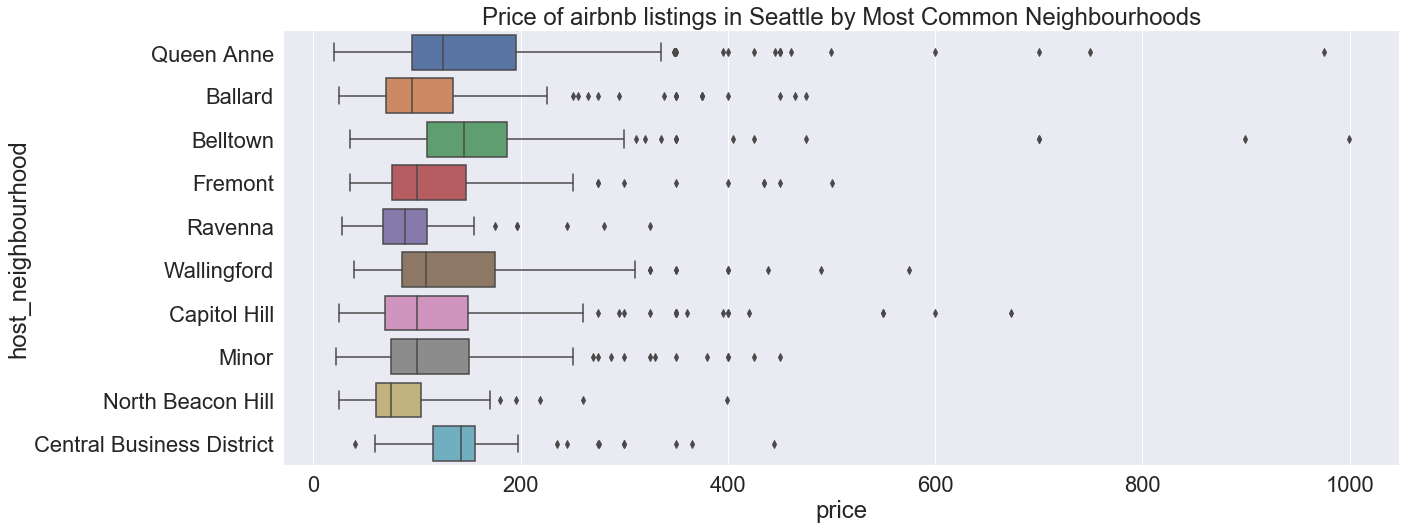

In [260]:
top_10_neighbourhoods = neighbourhood_prices.iloc[0:10,].index
top_10_neighbourhoods_df = df[df['host_neighbourhood'].isin(top_10_neighbourhoods)]


fig, ax = plt.subplots(figsize = dimensions)
ax = sns.boxplot(x="price", y="host_neighbourhood", data=top_10_neighbourhoods_df)
ax.set_title('Price of airbnb listings in Seattle by Most Common Neighbourhoods')

In [261]:
#There are very many Neighbourhoods, some with only 1 listing.  This is too many features to add to the model.
#Select only the top X areas to encode as categorical variables
neighbourhood_categorical_count = 60
most_common_neighbourhoods = df['host_neighbourhood'].value_counts().index[0:neighbourhood_categorical_count]
df['host_neighbourhood2'] = df['host_neighbourhood']
other_neighbour_hoods = ~df['host_neighbourhood'].isin(most_common_neighbourhoods)
df[other_neighbour_hoods]['c'] = 'Other'

In [262]:
#We should rollup other neighbourhoods into a single other category.  Otherwise we will have too many features
#and some features will only apply to a single (or few) observations
df.loc[other_neighbour_hoods, ['host_neighbourhood2']] = 'Other'

In [263]:
#df['host_neighbourhood2'] = df['host_neighbourhood']
df['host_neighbourhood2'].value_counts().head(20)

Other                        446
Capitol Hill                 405
Belltown                     254
Ballard                      210
Minor                        191
Queen Anne                   189
Fremont                      147
Wallingford                  134
North Beacon Hill            101
Ravenna                       99
Central Business District     93
Stevens                       87
First Hill                    85
Greenwood                     80
University District           80
Lower Queen Anne              75
Columbia City                 61
Green Lake                    55
North Admiral                 53
Magnolia                      53
Name: host_neighbourhood2, dtype: int64

In [264]:
#host_neighbourhood
host_neighbourhood_dummies = pd.get_dummies(df['host_neighbourhood2'], prefix='host_neighbourhood', drop_first=True)
df = pd.concat([df, host_neighbourhood_dummies], axis=1)
df.drop(columns=['host_neighbourhood', 'host_neighbourhood2'], inplace=True)

In [265]:
dummy_columns = dummy_columns + host_neighbourhood_dummies

### Numeric Features

In [266]:
feature_columns = ['bedrooms', 'bathrooms', 'accommodates', 'beds', 'square_feet','guests_included', 'number_of_reviews']

#Check potential feature columns for null values
df[feature_columns].isnull().sum().sort_values(ascending=False)

square_feet          3720
bathrooms              16
bathrooms              16
bedrooms                6
bedrooms                6
beds                    1
number_of_reviews       0
guests_included         0
accommodates            0
dtype: int64

In [267]:
#Only use feature columns if they do not have many nulls
feature_columns = ['bedrooms', 'bathrooms', 'accommodates', 'beds', 'guests_included', 'number_of_reviews']

In [268]:
#Features to use in the model
features = feature_columns + verification_features + amenities_features + dummy_columns.columns.to_list() + ['host_is_superhost']

#How many observations do we have?
print(len(df))

#Drop rows where a feature value is null
df = df.dropna(axis=0, how="any", thresh=None, subset=features, inplace=False)

#How many observations do we have left?
print(len(df))

3817
3793


## Train Model

In [269]:
#Target variable we are trying to predict
y = df['price']

In [270]:
X = df[features]

In [271]:
X.describe()

,bedrooms,bathrooms,accommodates,beds,guests_included,number_of_reviews,host_verifications_email,host_verifications_phone,host_verifications_reviews,host_verifications_kba,host_verifications_facebook,host_verifications_linkedin,host_verifications_jumio,host_verifications_google,host_verifications_manual_offline,host_verifications_amex,host_verifications_manual_online,host_verifications_sent_id,host_verifications_photographer,host_verifications_weibo,amenity_TV,amenity_Cable TV,amenity_Internet,amenity_Wireless Internet,amenity_Air Conditioning,amenity_Kitchen,amenity_Heating,amenity_Family/Kid Friendly,amenity_Washer,amenity_Dryer,amenity_Free Parking on Premises,amenity_Buzzer/Wireless Intercom,amenity_Smoke Detector,amenity_Carbon Monoxide Detector,amenity_First Aid Kit,amenity_Safety Card,amenity_Fire Extinguisher,amenity_Essentials,amenity_Pets Allowed,amenity_Pets live on this property,amenity_Dog(s),amenity_Cat(s),amenity_Hot Tub,amenity_Indoor Fireplace,amenity_Shampoo,amenity_Breakfast,amenity_24-Hour Check-in,amenity_Hangers,amenity_Hair Dryer,amenity_Iron,amenity_Laptop Friendly Workspace,amenity_Suitable for Events,amenity_Elevator in Building,amenity_Lock on Bedroom Door,amenity_Wheelchair Accessible,amenity_Gym,amenity_Pool,amenity_Smoking Allowed,amenity_Other pet(s),amenity_Doorman,amenity_Washer / Dryer,cancellation_policy_moderate,cancellation_policy_strict,host_neighbourhood_Atlantic,host_neighbourhood_Ballard,host_neighbourhood_Belltown,host_neighbourhood_Bitter Lake,host_neighbourhood_Broadview,host_neighbourhood_Bryant,host_neighbourhood_Capitol Hill,host_neighbourhood_Central Business District,host_neighbourhood_Columbia City,host_neighbourhood_Crown Hill,host_neighbourhood_Dunlap,host_neighbourhood_Eastlake,host_neighbourhood_First Hill,host_neighbourhood_Fremont,host_neighbourhood_Gatewood,host_neighbourhood_Genesee,host_neighbourhood_Green Lake,host_neighbourhood_Greenwood,host_neighbourhood_Haller Lake,host_neighbourhood_Harrison/Denny-Blaine,host_neighbourhood_High Point,host_neighbourhood_Highland Park,host_neighbourhood_Holly,host_neighbourhood_International District,host_neighbourhood_Leschi,host_neighbourhood_Licton Springs,host_neighbourhood_Lower Queen Anne,host_neighbourhood_Madison Park,host_neighbourhood_Madrona,host_neighbourhood_Magnolia,host_neighbourhood_Maple Leaf,host_neighbourhood_Mathews Beach,host_neighbourhood_Minor,host_neighbourhood_Montlake,host_neighbourhood_Mount Baker,host_neighbourhood_North Admiral,host_neighbourhood_North Beach/Blue Ridge,host_neighbourhood_North Beacon Hill,host_neighbourhood_North Delridge,host_neighbourhood_Olympic Hills,host_neighbourhood_Other,host_neighbourhood_Phinney Ridge,host_neighbourhood_Pike Place Market,host_neighbourhood_Pioneer Square,host_neighbourhood_Portage Bay,host_neighbourhood_Queen Anne,host_neighbourhood_Rainier Beach,host_neighbourhood_Ravenna,host_neighbourhood_Roosevelt,host_neighbourhood_Seward Park,host_neighbourhood_South Lake Union,host_neighbourhood_Stevens,host_neighbourhood_The Junction,host_neighbourhood_University District,host_neighbourhood_Victory Heights,host_neighbourhood_Wallingford,host_neighbourhood_Wedgewood,host_neighbourhood_Westlake,host_neighbourhood_Windermere,host_neighbourhood_Yesler Terrace,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,host_is_superhost
count,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.000000,3793.00

In [272]:
#Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [273]:
models = {}
models['LinearRegression'] = {'model': LinearRegression()} 
models['KNeighborsRegressor'] = {'model': KNeighborsRegressor()} 
models['SGDRegressor'] = {'model': SGDRegressor()} 
models['Lasso'] = {'model':  Lasso()}
models['ElasticNet'] = {'model':  ElasticNet()}
models['Ridge'] = {'model': Ridge()}
models['SVR-linear'] = {'model':  SVR(kernel='linear')}
models['SVR-rbf'] = {'model':  SVR(kernel='rbf')} 

In [274]:
for key in models.keys():
   print('MODEL: ', key)
   print('... fitting model') 
   models[key]['model'].fit(X_train, y_train)
   print('... predicting on test data') 
   y_pred = models[key]['model'].predict(X_test)
   models[key]['predictions'] = y_pred
   print('... evaluating test results') 
   MAE = mean_absolute_error(y_test, y_pred)
   print('MAE: ', MAE)
   RMSE = np.sqrt(MAE)
   print('RMSE: ', RMSE)
   R2 = r2_score(y_test, y_pred)
   print('R2: ', R2)
   models[key]['metrics'] = {}
   models[key]['metrics']['MAE'] = MAE
   models[key]['metrics']['RMSE'] = RMSE
   models[key]['metrics']['R2'] = R2
   print('\n')

MODEL:  LinearRegression
... fitting model
... predicting on test data
... evaluating test results
MAE:  36.79530948083102
RMSE:  6.065913738327559
R2:  0.6264050211421208


MODEL:  KNeighborsRegressor
... fitting model
... predicting on test data
... evaluating test results
MAE:  43.2261862917399
RMSE:  6.574662446980826
R2:  0.42813448242173235


MODEL:  SGDRegressor
... fitting model
... predicting on test data
... evaluating test results
MAE:  84.38617032620105
RMSE:  9.186194550857339
R2:  -27.088959238924712


MODEL:  Lasso
... fitting model
... predicting on test data
... evaluating test results
MAE:  35.544286301321016
RMSE:  5.961902909417514
R2:  0.627147586153892


MODEL:  ElasticNet
... fitting model
... predicting on test data
... evaluating test results
MAE:  35.9841454639495
RMSE:  5.998678643163801
R2:  0.6069550354272006


MODEL:  Ridge
... fitting model
... predicting on test data
... evaluating test results
MAE:  36.79430943140317
RMSE:  6.065831305880767
R2:  0.6264

In [275]:
for key in models.keys():
    print('MODEL: ', key)
    model =  models[key]['model']
    #Cross Folds Validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(cv_scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
    print('\n')

MODEL:  LinearRegression
[0.60873957 0.38450988 0.41418715 0.53712477 0.48518995]
Accuracy: 0.49 (+/- 0.16)


MODEL:  KNeighborsRegressor
[0.54429883 0.31990952 0.39401378 0.56517842 0.46710894]
Accuracy: 0.46 (+/- 0.18)


MODEL:  SGDRegressor
[-1.09330397e+19 -5.97864705e+17 -1.23800762e+20 -1.25765374e+19
 -2.58578890e+17]
Accuracy: -29633356561643687936.00 (+/- 94716733696938082304.00)


MODEL:  Lasso
[0.61239951 0.41223219 0.4579406  0.61462566 0.50982721]
Accuracy: 0.52 (+/- 0.16)


MODEL:  ElasticNet
[0.55445021 0.38623197 0.41907814 0.57261326 0.46734467]
Accuracy: 0.48 (+/- 0.15)


MODEL:  Ridge
[0.61188949 0.3969249  0.48579174 0.57681354 0.51557555]
Accuracy: 0.52 (+/- 0.15)


MODEL:  SVR-linear
[0.54000751 0.42063806 0.51533402 0.56860002 0.49741692]
Accuracy: 0.51 (+/- 0.10)


MODEL:  SVR-rbf
[0.18567908 0.12895055 0.28972424 0.25592676 0.22997459]
Accuracy: 0.22 (+/- 0.11)




Ridge, Lasso, SVR-Linear and ElasticNet were the top performing algorithms according to this cross folds validation.
Ridge, Lasso and ElasticNet could all potentially be fine tuned with hyperparameters.

In [276]:
#Create new empty dictionary
models_to_tune = {}

#Set range of values to try for hyperparameters
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = np.linspace(0.0,1.0,11)

#Add models to dictionary and their hyperparameters
models_to_tune['Lasso'] = models['Lasso']
models_to_tune['Lasso']['param_grid'] = dict(alpha=alpha)

models_to_tune['ElasticNet'] = models['ElasticNet']
models_to_tune['ElasticNet']['param_grid'] = dict(alpha=alpha)

models_to_tune['Ridge'] = models['Ridge']
models_to_tune['Ridge']['param_grid'] = dict(alpha=alpha)

In [277]:
for key in models_to_tune.keys():
    print('MODEL: ', key)
    model =  models_to_tune[key]['model']
    param_grid = models_to_tune[key]['param_grid']
    #Cross Folds Validation
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
    grid_result = grid.fit(X_train, y_train)
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    print('\n')

MODEL:  Lasso
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Score:  0.5528221605611688
Best Params:  {'alpha': 1}


MODEL:  ElasticNet
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.2s


Best Score:  0.5466797875546244
Best Params:  {'alpha': 1}


MODEL:  Ridge
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Score:  0.5459879301091495
Best Params:  {'alpha': 1000}




[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.2s finished


### Lasso

The GridSearch results suggest that the Lasso algorithm performed best when the alpha hyperparameter was set to 1.0

In [278]:
bestmodel = Lasso(alpha=0.1)
bestmodel.fit(X_train, y_train)
y_pred = bestmodel.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('MAE: ', MAE)
RMSE = np.sqrt(MAE)
print('RMSE: ', RMSE)
R2 = r2_score(y_test, y_pred)
print('R2: ', R2)

MAE:  36.57687795018697
RMSE:  6.047882104521133
R2:  0.628310837981283


### Examining the Coefficients

In [279]:
coeff_df = pd.DataFrame(bestmodel.coef_, X.columns, columns = ['Coefficient'])
coeff_df.sort_values('Coefficient', ascending=False).head(10)

,Coefficient
bedrooms,24.759392
accommodates,17.208452
bathrooms,15.270701
host_neighbourhood_Belltown,5.260786
amenity_Elevator in Building,5.138810
property_type_Boat,4.852765
amenity_Hot Tub,4.320434
amenity_Doorman,4.214612
host_neighbourhood_Montlake,4.065348
host_neighbourhood_Queen Anne,4.034717


As our initial EDA demonstrated, the number of bedrooms, how many people the property accomodates and the number of bathrooms strongly correlate with increased price.  These were the top performing positive features in the model.
The next top performing positive feature was the categorical indicator that the property is located in Belltown.  This is likely to be one of the most attractive areas of Seattle.  Having an elevator, hot tub, doorman or being a boat also strongly helped predict the price.

In [280]:
coeff_df.sort_values('Coefficient', ascending=True).head(10)

,Coefficient
room_type_Private room,-16.645263
room_type_Shared room,-12.843608
number_of_reviews,-4.265469
host_neighbourhood_Crown Hill,-3.972528
host_neighbourhood_Haller Lake,-3.725827
host_neighbourhood_Seward Park,-3.430275
host_neighbourhood_North Beacon Hill,-3.426319
host_verifications_reviews,-3.308327
host_neighbourhood_Greenwood,-3.303933
amenity_Hangers,-3.283073


Being a private or shared room tends to result in a much cheaper price.  A higher number of reviews tends to lead to a lower price too.  Several neighbourhood features are also present in the top negative coefficients.

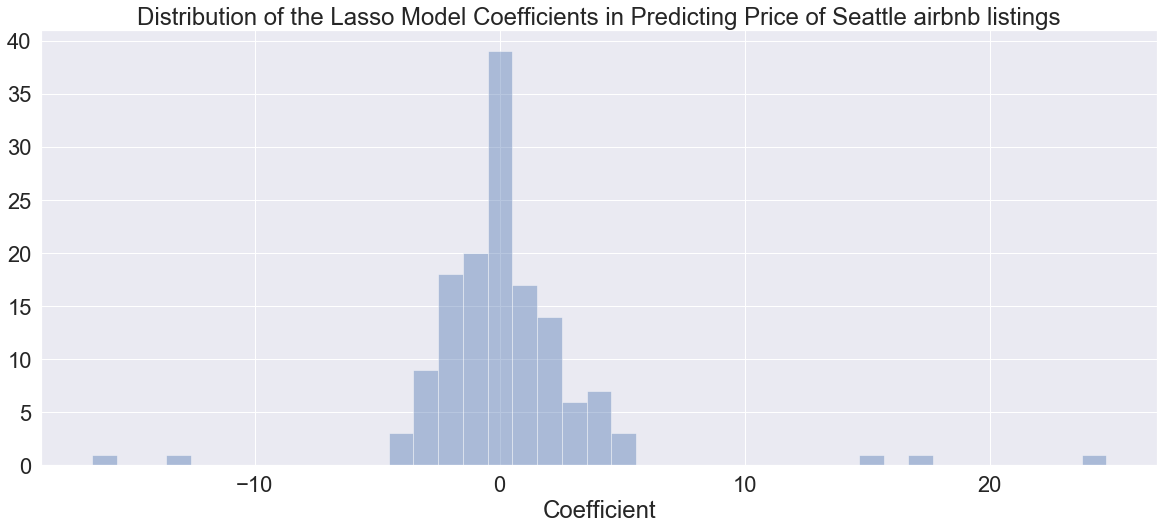

In [281]:
#Plot Histogram of the Model Coefficients
fig, ax = plt.subplots(figsize = dimensions)
sns.distplot(coeff_df['Coefficient'],kde = False)
ax.set_title('Distribution of the Lasso Model Coefficients in Predicting Price of Seattle airbnb listings')
plt.show()

The histogram shows that most of the features had a coefficient fairly close to zero.  There were many coefficents between -5 and + 5, which suggests that have some predictive power in the model.  However the majority of the predictive power comes from 3 positive coefficients and two negative coefficients (see on either end of the histogram).

In [282]:
df.groupby('bedrooms')['price'].agg(['count', 'min', 'mean', 'max', 'std']).sort_values('count', ascending=False)

,count,min,mean,max,std
bedrooms,,,,,
1.0,2403,20.0,95.554307,999.0,49.327930
2.0,636,49.0,172.900943,700.0,80.070154
0.0,371,39.0,103.560647,375.0,35.575173
3.0,283,65.0,249.530035,950.0,119.819286
4.0,69,150.0,313.695652,775.0,122.384676
5.0,24,225.0,441.000000,975.0,150.149491
6.0,6,461.0,578.166667,750.0,111.278779
7.0,1,375.0,375.000000,375.0,NaN


In [283]:
#Calculate The Errors
errors = (y_test) - (y_pred)
absolute_errors = (abs((y_test) - (y_pred)))
absolute_errors.mean()

36.576877950187

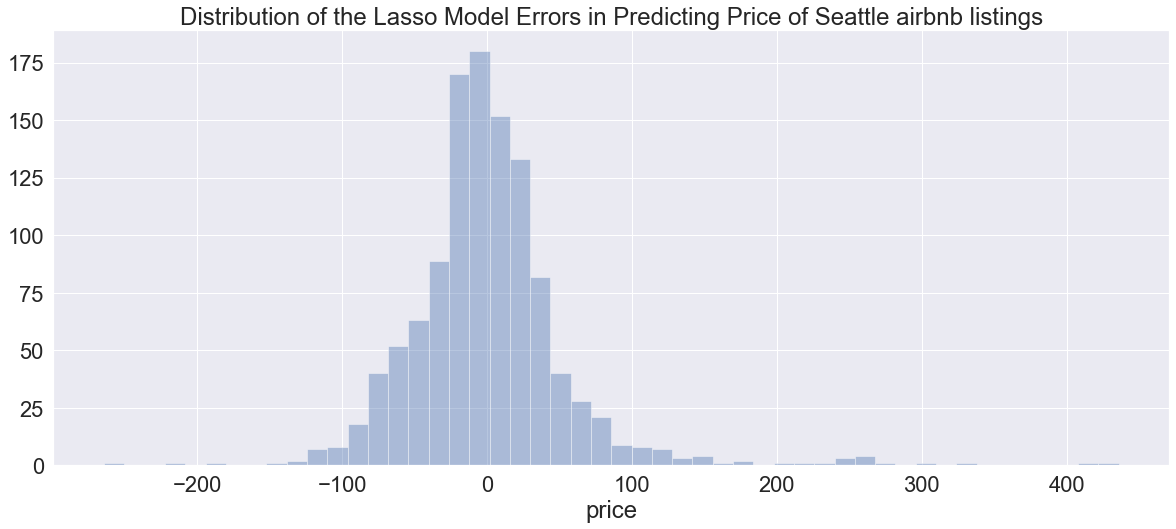

In [284]:
#Plot Histogram of the model errors
fig, ax = plt.subplots(figsize = dimensions)
sns.distplot(errors,kde = False)
ax.set_title('Distribution of the Lasso Model Errors in Predicting Price of Seattle airbnb listings')
plt.show()

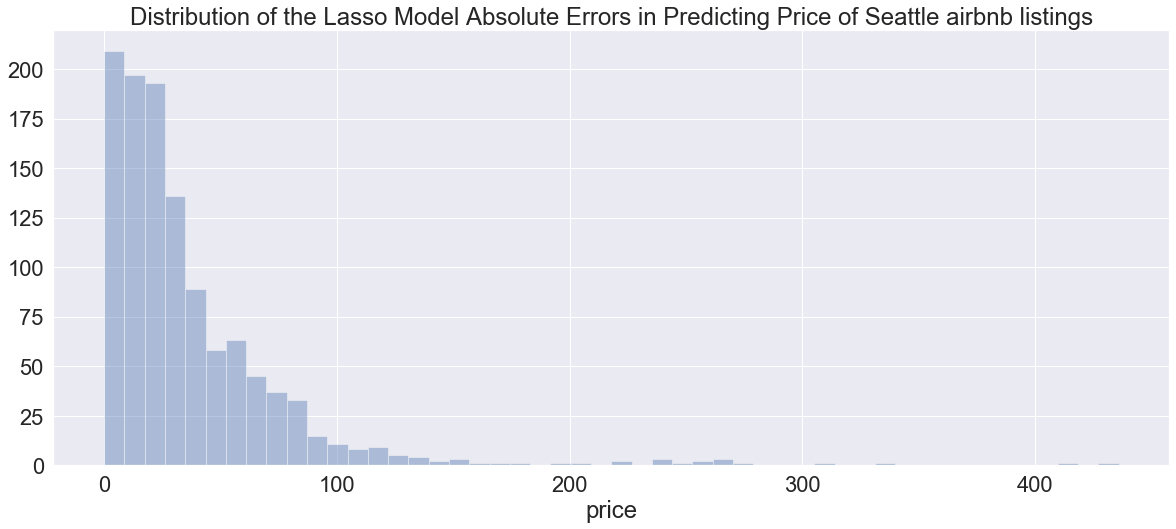

In [285]:
#Plot Histogram of the model absolute errors
fig, ax = plt.subplots(figsize = dimensions)
sns.distplot(absolute_errors,kde = False)
ax.set_title('Distribution of the Lasso Model Absolute Errors in Predicting Price of Seattle airbnb listings')
plt.show()

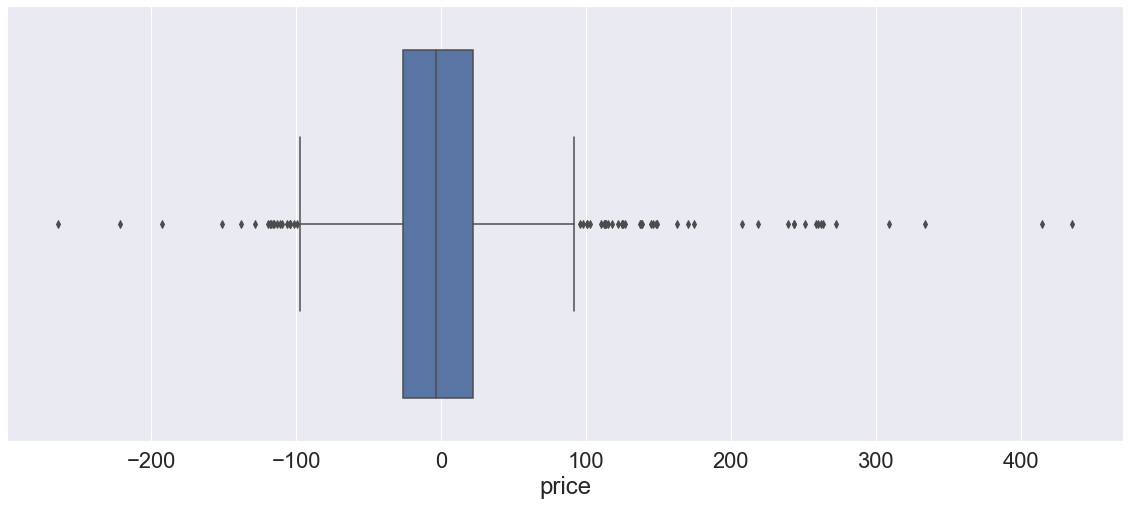

In [286]:
#Boxplot of the model errors
fig, ax = plt.subplots(figsize = dimensions)
ax = sns.boxplot(x=errors)